
# *TP1: Image Classiﬁcation and Regression*


In [0]:
%matplotlib inline
#from mp1 import *
import keras
from keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from keras.models import Sequential, clone_model
from keras.regularizers import l2, l1
from keras import optimizers
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from IPython.display import clear_output


In [0]:
###mp1 code
import matplotlib.pyplot as plt 
import numpy as np # On some implementations of matplotlib, you may need to change this value
from keras.utils import np_utils


IMAGE_SIZE = 72
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size) 
    plt.close(fig)
    return imdata


def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:

        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top

    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

#im = generate_a_rectangle(10, True)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
#im = generate_a_disk(10)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
#[im, v] = generate_a_triangle(20, False)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    #print('Creating data')
    for i in range(nb_samples):
        #if i % 10 == 0:
            #print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1:
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    print('Data created')
    return [X, Y]


def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3)
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    #print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
            #print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    print('Data created:')
    return [X, Y]


import matplotlib.patches as patches
def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1]) 
    ax.set_ylim([0,1])
    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)
    plt.show()


def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# *Simple Classification*


In [0]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
[X_test, Y_test] = generate_dataset_classification(100, 20)

Data created
Data created


#* With stochastic gradient descent optimizer *

In [0]:
print('The shape of X_train is '+ str(X_train.shape))

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

The shape of X_train is (300, 5184)


In [0]:
#Defining the network

linear_model_sgd = Sequential()
#Using the 'softmax' as activation
linear_model_sgd.add(Dense(3, activation='softmax'))

learning_rate = 0.01
sgd = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=False)
linear_model_sgd.compile(optimizer=sgd, loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="Train Loss")
        plt.plot(self.x, self.val_losses, label="Test Loss")
        plt.legend()
        plt.show();
        
LossHistory = LossHistory()

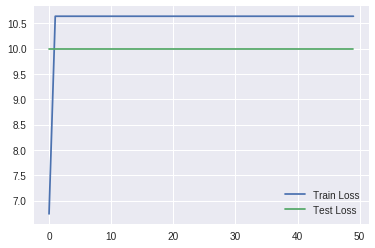

In [0]:
linear_model_sgd.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=50, batch_size=32, callbacks=[LossHistory])

We notice that the loss is saturated. 

In [0]:
train = linear_model_sgd.evaluate(X_train, Y_train)
test = linear_model_sgd.evaluate(X_test, Y_test)

print('SGD Model Train performance: ','loss of '+str(train[0])+' and acc of '+str(train[1]))
print('SGD Model Test performance: ','loss of '+str(test[0])+' and acc of '+str(test[1]))


100/100 [==============================] - 0s 173us/step
SGD Model Train performance:  loss of 10.637942905426025 and acc of 0.3400000007947286
SGD Model Test performance:  loss of 9.993218994140625 and acc of 0.38


We can notice that the loss is high.

# *With adam optimizer*

In [0]:
linear_model_adam = Sequential()
#Using the 'softmax' as activation
linear_model_adam.add(Dense(3, activation='softmax'))

#Optimizing the network with stochastic gradient descent
linear_model_adam.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics=['accuracy'])

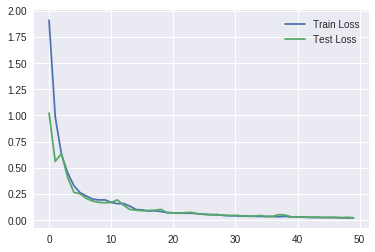

In [0]:
linear_model_adam.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=50, batch_size=32, callbacks=[LossHistory])

The train and test loss decrease.

In [0]:
train = linear_model_adam.evaluate(X_train, Y_train)
test = linear_model_adam.evaluate(X_test, Y_test)

print('SGD Model Train performance: ','loss of '+str(train[0])+' and acc of '+str(train[1]))
print('SGD Model Test performance: ','loss of '+str(test[0])+' and acc of '+str(test[1]))


100/100 [==============================] - 0s 174us/step
SGD Model Train performance:  loss of 0.019265136135121187 and acc of 1.0
SGD Model Test performance:  loss of 0.022182158157229424 and acc of 1.0


The train loss is much better and the accuracy as well for Adam model.

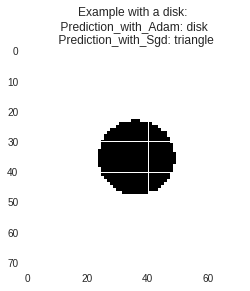

In [0]:
output={0:'rectangle', 1: 'disk', 2: 'triangle'}

X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
Y_pred_Adam = linear_model_adam.predict(X_test)
Y_pred_Sgd = linear_model_sgd.predict(X_test)
Y_pred_and_true=[output[np.argmax(Y_pred_Adam)], output[np.argmax(Y_pred_Sgd)]]
plt.imshow(X_test[0].reshape(72,72), cmap='gray')
plt.title('Example with a disk: \n Prediction_with_Adam: %s \n Prediction_with_Sgd: %s' % (Y_pred_and_true[0],Y_pred_and_true[1]))
plt.show()

# *Visualization of the solution with stochastic gradient descent*

Text(0.5,1,'Visualisation of third Column of W (triangle)')

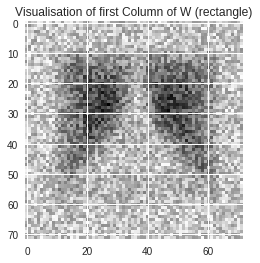

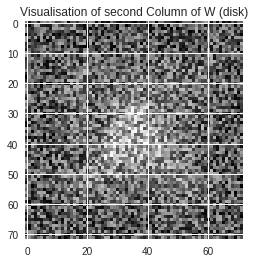

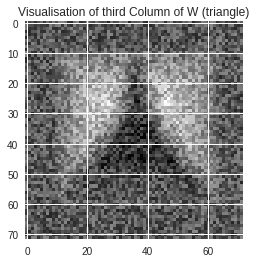

In [0]:
W,b = linear_model_sgd.get_weights()

plt.figure(1)
plt.imshow(W[:,0].reshape(72,72), cmap='gray')
plt.title('Visualisation of first Column of W (rectangle)')

plt.figure(2)
plt.imshow(W[:,1].reshape(72,72), cmap='gray')
plt.title('Visualisation of second Column of W (disk)')

plt.figure(3)
plt.imshow(W[:,2].reshape(72,72), cmap='gray')
plt.title('Visualisation of third Column of W (triangle)')

#* Visualization of the solution with Adam*

Text(0.5,1,'Visualisation of third Column of W (triangle)')

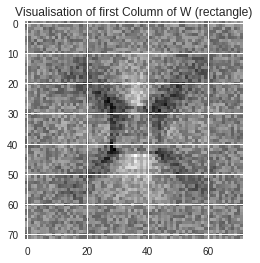

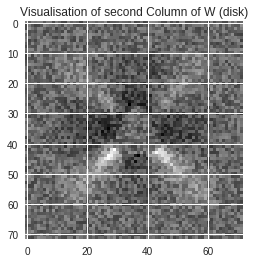

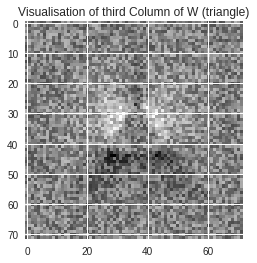

In [0]:
W,b = linear_model_adam.get_weights()

plt.figure(1)
plt.imshow(W[:,0].reshape(72,72), cmap='gray')
plt.title('Visualisation of first Column of W (rectangle)')

plt.figure(2)
plt.imshow(W[:,1].reshape(72,72), cmap='gray')
plt.title('Visualisation of second Column of W (disk)')

plt.figure(3)
plt.imshow(W[:,2].reshape(72,72), cmap='gray')
plt.title('Visualisation of third Column of W (triangle)')

We can notice that we have better results with Adam than with Stochastic gradient descent which are visible when plotting the weighs.

# *A more difficult classification problem*

Here we will a convolution neural network which principle is summarized in the below image.
![Convolution Neural Network](https://cdn-images-1.medium.com/max/1000/1*N4h1SgwbWNmtrRhszM9EJg.png)

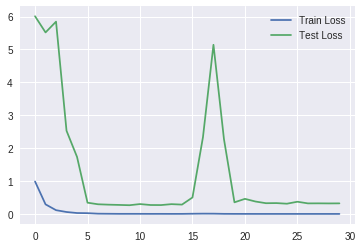

In [0]:
[X_train, Y_train] = generate_dataset_classification(600, 20, True)
[X_test, Y_test] = generate_test_set_classification()

Y_train = to_categorical(Y_train)

X_train = X_train.reshape((600,72,72,1))

X_test = X_test.reshape((300,72,72,1))

##With convolution Neural Network

modelCNN = Sequential()
modelCNN.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(72,72,1), activation='relu'))
modelCNN.add(BatchNormalization())
modelCNN.add(MaxPooling2D((4,4)))
modelCNN.add(Dropout(0.5))
modelCNN.add(Flatten())
modelCNN.add(Dense(124, activation='relu'))
modelCNN.add(Dense(3, activation='softmax'))
modelCNN.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

modelCNN.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=30,batch_size=32, callbacks=[LossHistory])

In [0]:
train = modelCNN.evaluate(X_train, Y_train)
test = modelCNN.evaluate(X_test, Y_test)

print('SGD Model Train performance: ','loss of '+str(train[0])+' and acc of '+str(train[1]))
print('SGD Model Test performance: ','loss of '+str(test[0])+' and acc of '+str(test[1]))


300/300 [==============================] - 0s 260us/step
SGD Model Train performance:  loss of 5.965216031957728e-05 and acc of 1.0
SGD Model Test performance:  loss of 0.3209455852707227 and acc of 0.926666665871938


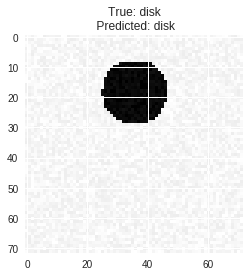

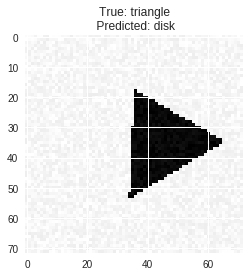

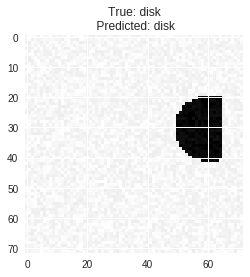

In [0]:
import matplotlib.pyplot as plt

output={0:'rectangle', 1: 'disk', 2: 'triangle'}

plt.figure(1)
Y_pred = modelCNN.predict(X_test[0].reshape(1,72,72,1))
Y_pred_and_true=[output[np.argmax(Y_test[0])], output[np.argmax(Y_pred)]]
plt.imshow(X_test[0].reshape(72,72), cmap='gray')
plt.title('True: %s\n Predicted: %s' % (Y_pred_and_true[0], Y_pred_and_true[1]))
plt.show()

plt.figure(2)
Y_pred = modelCNN.predict(X_test[1].reshape(1,72,72,1))
Y_pred_and_true=[output[np.argmax(Y_test[1])], output[np.argmax(Y_pred)]]
plt.imshow(X_test[1].reshape(72,72), cmap='gray')
plt.title('True: %s\n Predicted: %s' % (Y_pred_and_true[0], Y_pred_and_true[1]))
plt.show()

plt.figure(3)
Y_pred = modelCNN.predict(X_test[2].reshape(1,72,72,1))
Y_pred_and_true=[output[np.argmax(Y_test[2])], output[np.argmax(Y_pred)]]
plt.imshow(X_test[2].reshape(72,72), cmap='gray')
plt.title('True: %s\n Predicted: %s' % (Y_pred_and_true[0], Y_pred_and_true[1]))
plt.show()

# *Regression Problem*

In [0]:
[X_train, Y_train] = generate_dataset_regression(1000, 20)
[X_test, Y_test] = generate_test_set_regression()

X_train = X_train.reshape(1000,72,72,1)
X_test = X_test.reshape(300,72,72,1)

Data created:
Data created:


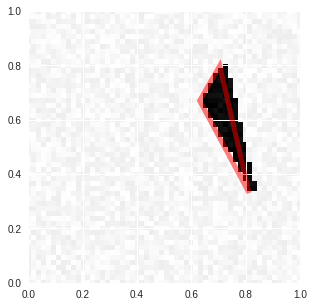

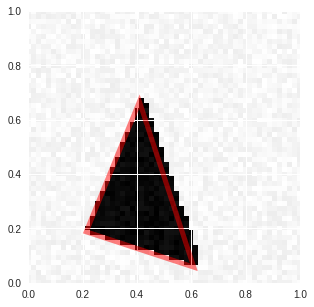

In [0]:
for i in range(2):
    visualize_prediction(X_train[i], Y_train[i])

Sorting the components of Y following x and centralise them is essential here otherwise the network won't learn correctly. 

In [0]:
def sort_figure(data):
    """
    Description:
    ------------------
    Sorting and centralizing the vectors 
    
    Parameter:
    ------------------
    data
    
    Output
    ------------------
    vector of sorted and centralized data shape of (6,)
    
    """
    center = 0.5
    #center = 0
    max_elements = np.max([data[2*j] for j in range(3)])
    i_max = np.argmax([data[2*j] for j in range(3)])
        
    min_elements = np.min([data[2*j] for j in range(3)])
    i_min = np.argmin([data[2*j] for j in range(3)])
        
    i_medium = 3-i_max-i_min
    medium_element = data[2*i_medium]
    
    return np.array([data[2*i_max]-center, data[2*i_max+1]-center, 
                     data[2*i_medium]-center, data[2*i_medium+1]-center, 
                     data[2*i_min]-center, data[2*i_min+1]-center])

Sorting the vectors

In [0]:
Y_train_sorted = np.zeros((Y_train.shape[0], Y_train.shape[1]))
Y_test_sorted = np.zeros((Y_test.shape[0], Y_test.shape[1]))

for i in range(len(Y_train)):
    Y_train_sorted[i,:]=sort_figure(Y_train[i,:])
for i in range(len(Y_test)):
    Y_test_sorted[i,:]=sort_figure(Y_test[i,:])

In [0]:
reg = 0.00001

model_sorted = Sequential()

model_sorted.add(Conv2D(filters=32, kernel_size=(5,5), input_shape=(72,72,1), activation='relu', kernel_regularizer=l2(reg)))
# model_sorted.add(BatchNormalization())
model_sorted.add(MaxPooling2D((5, 5), padding='valid'))
model_sorted.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu'))
# model_sorted.add(BatchNormalization())
model_sorted.add(MaxPooling2D((2, 2), padding='valid'))
model_sorted.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
# model_sorted.add(BatchNormalization())


model_sorted.add(Flatten())
model_sorted.add(Dense(256, activation='relu'))
model_sorted.add(Dense(124, activation='relu'))
model_sorted.add(Dense(64, activation='relu', kernel_regularizer=l2(reg)))
model_sorted.add(Dense(6, activation='tanh'))

model_sorted.compile(optimizer='adam', loss='mean_absolute_error')

In [0]:
model_sorted.fit(X_train, Y_train_sorted, validation_data=(X_test, Y_test_sorted),epochs=100, batch_size = 64)

Train on 1000 samples, validate on 300 samples
Epoch 1/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2121 - val_loss: 0.1825
Epoch 2/100
1000/1000 [==============================] - 0s 341us/step - loss: 0.1658 - val_loss: 0.1400
Epoch 3/100
1000/1000 [==============================] - 0s 353us/step - loss: 0.1305 - val_loss: 0.1177
Epoch 4/100
1000/1000 [==============================] - 0s 336us/step - loss: 0.1140 - val_loss: 0.1078
Epoch 5/100
1000/1000 [==============================] - 0s 327us/step - loss: 0.1023 - val_loss: 0.1008
Epoch 6/100
1000/1000 [==============================] - 0s 358us/step - loss: 0.0937 - val_loss: 0.0980
Epoch 7/100
1000/1000 [==============================] - 0s 332us/step - loss: 0.0838 - val_loss: 0.0893
Epoch 8/100
1000/1000 [==============================] - 0s 333us/step - loss: 0.0769 - val_loss: 0.0868
Epoch 9/100
1000/1000 [==============================] - 0s 335us/step - loss: 0.0717 - val_loss: 0.0811
Epoch 10/1

In [0]:
#Finction for the visualisation of the prediction
def visualisation(data, index, is_print=False):
    y_test_predict = model_sorted.predict(data[index].reshape(1,72,72,1))+0.5
    if is_print:
      print('With prediction with sorted model '+ str(y_test_predict[0]))
      print('With the True prediction ' + str(Y_test[index]))
    visualize_prediction(data[index].reshape(1,72,72,1), y_test_predict[0])

Here is a test predicting an element of the train data, we notice that the train data is well predicted wich is inline with the very low training loss.

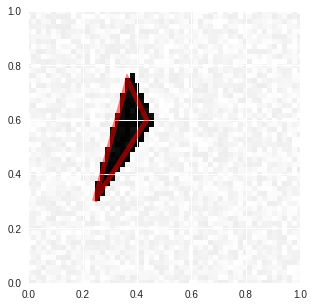

In [0]:
data_set = X_train
index = np.random.choice(range(len(X_train)))

visualisation(data_set, index, is_print=False)

Here are the results of the prediction for test data. We obtain pretty good results as well.

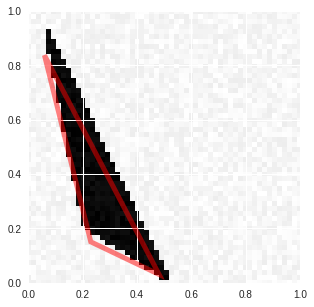

In [0]:
index = np.random.choice(range(len(X_test)))
visualisation(X_test, index, is_print=False)

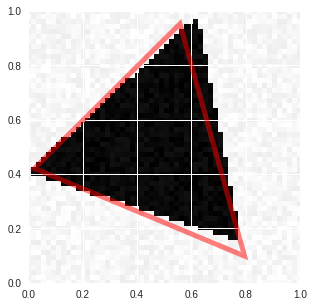

In [0]:
index = np.random.choice(range(len(X_test)))
visualisation(X_test, index, is_print=False)

# *Image Denoising*

We modify the functions of mp1.py to generate a pair of drawings: one with the noise and the other without. 

In [0]:
#RECTANGLE
def generate_a_rectangle_pair(noise=0.0, free_location=False):
    figsize = 1.0
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:

        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top

    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, noise=0.0)

#DISK
def generate_a_disk_pair(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, noise=0.0)

#TRIANGLE
def generate_a_triangle_pair(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, noise=0.0)

#CLASSIFICATION
def generate_dataset_classification_pair(nb_samples, noise_amp=500, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X_noised = np.zeros([nb_samples,im_size])
    Y_noised = np.zeros(nb_samples)
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    #print('Creating data')
    for i in range(nb_samples):
        #if i % 10 == 0:
            #print(i)
        category = np.random.randint(3)
        noise = np.random.uniform(0, noise_amp)
        if category == 0:
            X_noised[i], X[i] = generate_a_rectangle_pair(noise, free_location)
            X_noised[i] = (X_noised[i] + noise) / (255 + 2 * noise)
            X[i] = X[i]/255
        elif category == 1:
            X_noised[i], X[i] = generate_a_disk_pair(noise, free_location)
            X_noised[i] = (X_noised[i] + noise) / (255 + 2 * noise)
            X[i] = X[i]/255        
        else:
            X_noised[i], X[i] = generate_a_triangle_pair(noise, free_location)
            X_noised[i] = (X_noised[i] + noise) / (255 + 2 * noise)
            X[i] = X[i]/255        
    print('Data created')
    return [X_noised, X]  

In [0]:
IMAGE_SIZE = 72
im_noise, im_no_noise = generate_dataset_classification_pair(1)

Data created


Text(0.5,1,'Example of noised image')

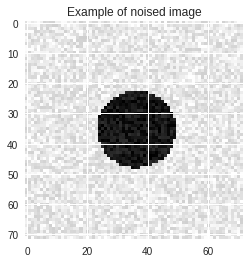

In [0]:
plt.imshow(im_noise.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title('Example of noised image')

Text(0.5,1,'Example of non noised image')

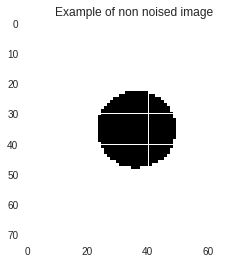

In [0]:
plt.imshow(im_no_noise.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title('Example of non noised image')

We create the noised train data, non noised train data, noised test data and non noised data.

In [0]:
im_noise, im_no_noise = generate_dataset_classification_pair(1000)
im_noise_test, im_no_noise_test = generate_dataset_classification_pair(100)

im_noise = im_noise.reshape(1000,72,72,1)
im_no_noise = im_no_noise.reshape(1000,72,72,1)
im_noise_test = im_noise_test.reshape(100,72,72,1)
im_no_noise_test = im_no_noise_test.reshape(100,72,72,1)

Data created
Data created


We used the structure of autoencoder  for denoising, the principle is based on an encoding part and a decoding part. This link explains well the principle
[deep-learning-types-and-autoencoders](https://codeburst.io/deep-learning-types-and-autoencoders-a40ee6754663)

![Autoencoder principle](https://cdn-images-1.medium.com/max/1750/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)




In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

model_autoencoder = Sequential()

model_autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model_autoencoder.add(MaxPooling2D((2, 2)))
model_autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model_autoencoder.add(MaxPooling2D((2, 2)))
model_autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model_autoencoder.add(MaxPooling2D((2, 2)))

model_autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model_autoencoder.add(UpSampling2D((2, 2)))
model_autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model_autoencoder.add(UpSampling2D((2, 2)))
model_autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding = 'same'))
model_autoencoder.add(UpSampling2D((2, 2)))
model_autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

model_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [0]:
model_autoencoder.fit(im_noise, im_no_noise, epochs=100, batch_size = 64)

Epoch 1/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6806
Epoch 2/100
1000/1000 [==============================] - 0s 462us/step - loss: 0.5371
Epoch 3/100
1000/1000 [==============================] - 0s 447us/step - loss: 0.4358
Epoch 4/100
1000/1000 [==============================] - 0s 424us/step - loss: 0.3153
Epoch 5/100
1000/1000 [==============================] - 0s 419us/step - loss: 0.2279
Epoch 6/100
1000/1000 [==============================] - 0s 430us/step - loss: 0.1820
Epoch 7/100
1000/1000 [==============================] - 0s 433us/step - loss: 0.1318
Epoch 8/100
1000/1000 [==============================] - 0s 422us/step - loss: 0.1237
Epoch 9/100
1000/1000 [==============================] - 0s 427us/step - loss: 0.1039
Epoch 10/100
1000/1000 [==============================] - 0s 431us/step - loss: 0.0808
Epoch 11/100
1000/1000 [==============================] - 0s 427us/step - loss: 0.0735
Epoch 12/100
1000/1000 [==============================

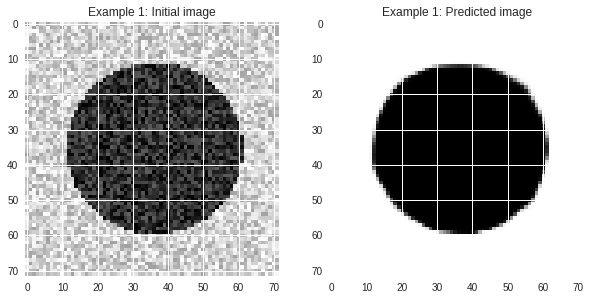

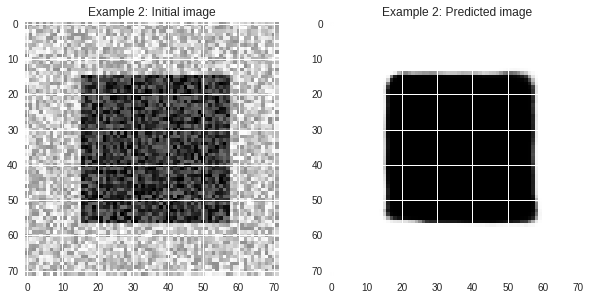

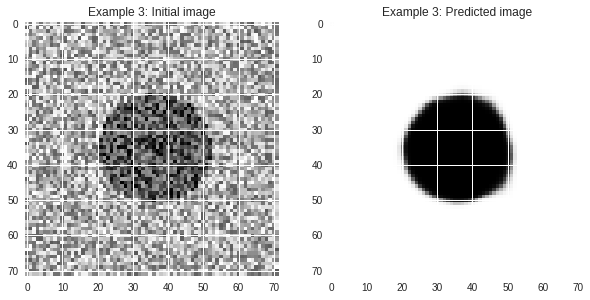

In [0]:
decoded_im_noise = model_autoencoder.predict(im_noise_test)
IMAGE_SIZE = 72

plt.figure(1, figsize=(10, 10))

index = np.random.choice(range(len(decoded_im_noise)))

plt.subplot(1,2,1)
plt.imshow(im_noise_test[index].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title('Example 1: Initial image')

plt.subplot(1,2,2)
plt.imshow(decoded_im_noise[index].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title('Example 1: Predicted image')
plt.show()


plt.figure(2, figsize=(10, 10))

index = np.random.choice(range(len(decoded_im_noise)))

plt.subplot(1,2,1)
plt.imshow(im_noise_test[index].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title('Example 2: Initial image')

plt.subplot(1,2,2)
plt.imshow(decoded_im_noise[index].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title('Example 2: Predicted image')
plt.show()


plt.figure(3, figsize=(10, 10))

index = np.random.choice(range(len(decoded_im_noise)))

plt.subplot(1,2,1)
plt.imshow(im_noise_test[index].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title('Example 3: Initial image')

plt.subplot(1,2,2)
plt.imshow(decoded_im_noise[index].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title('Example 3: Predicted image')
plt.show()

We notice that the denoising is quite good.